In [1]:
import os
import sys
import numpy as np


import umap.umap_ as umap

#add the parent folder to sys path so we can import from the notebook subfolder
sys.path.insert(0,'..')


#ALLDIR='/mnt/d/DATA/XFMDATA/2023/Nicholls_Loren/mounts_ansto_230418/230420_qz200um_cut/tiff'
BASEDIR = ""
TIFDIR = "/home/lachlan/DATA/datasets/XFMDATA/Zoe/slides_99um/s4"
EXT='.tiff'

image_directory = os.path.join(BASEDIR, TIFDIR)
#image_directory = ALLDIR

/home/lachlan/DATA/datasets/XFMDATA/Zoe/slides_99um/s4
['/home/lachlan/DATA/datasets/XFMDATA/Zoe/slides_99um/s4/full_99um_s4_cali-Al.tiff', '/home/lachlan/DATA/datasets/XFMDATA/Zoe/slides_99um/s4/full_99um_s4_cali-As.tiff', '/home/lachlan/DATA/datasets/XFMDATA/Zoe/slides_99um/s4/full_99um_s4_cali-Ca.tiff', '/home/lachlan/DATA/datasets/XFMDATA/Zoe/slides_99um/s4/full_99um_s4_cali-Cl.tiff', '/home/lachlan/DATA/datasets/XFMDATA/Zoe/slides_99um/s4/full_99um_s4_cali-Cr.tiff', '/home/lachlan/DATA/datasets/XFMDATA/Zoe/slides_99um/s4/full_99um_s4_cali-Cu.tiff', '/home/lachlan/DATA/datasets/XFMDATA/Zoe/slides_99um/s4/full_99um_s4_cali-Fe.tiff', '/home/lachlan/DATA/datasets/XFMDATA/Zoe/slides_99um/s4/full_99um_s4_cali-K.tiff', '/home/lachlan/DATA/datasets/XFMDATA/Zoe/slides_99um/s4/full_99um_s4_cali-Mg.tiff', '/home/lachlan/DATA/datasets/XFMDATA/Zoe/slides_99um/s4/full_99um_s4_cali-Mn.tiff', '/home/lachlan/DATA/datasets/XFMDATA/Zoe/slides_99um/s4/full_99um_s4_cali-Na.tiff', '/home/lachlan/DATA/d

Epochs completed:   0%|            0/200 [00:00]

Fri May 12 16:07:41 2023 Finished embedding
CALCULATING CATS
RUNNING CLUSTERING
DBSCAN PARAM 0.001, 0.001
cluster -1, count: 552
cluster 0, count: 3536
cluster 1, count: 2135
cluster 2, count: 2740
cluster 3, count: 1461
cluster 4, count: 246
cluster 5, count: 3638
-----Na tracker: 0.10000000149011612
8
(16412,)
-1
0


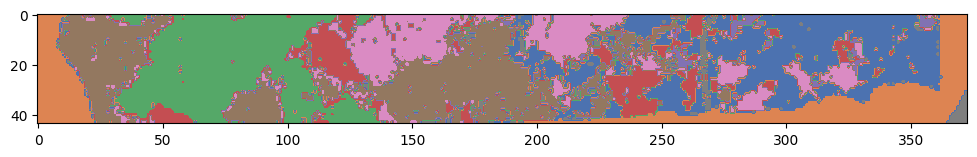

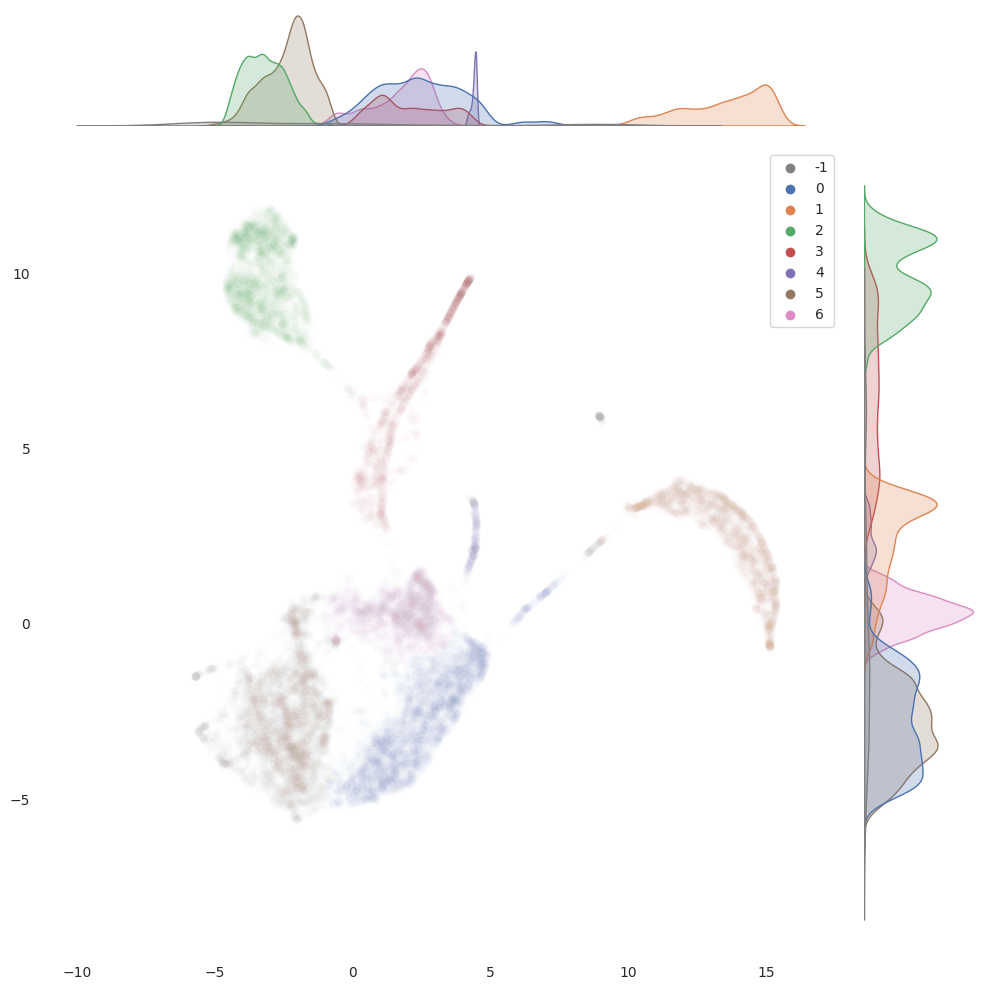

Al, max: 0.50, 98: 0.16, avg: 0.03
As, max: 0.09, 98: 0.05, avg: 0.03
Ca, max: 1.21, 98: 0.86, avg: 0.09
Cl, max: 1.00, 98: 0.74, avg: 0.09
Cr, max: 1.60, 98: 0.08, avg: 0.01
Cu, max: 0.16, 98: 0.01, avg: 0.00
Fe, max: 2.39, 98: 0.49, avg: 0.23
K, max: 0.07, 98: 0.02, avg: 0.00
Mg, max: 0.10, 98: 0.05, avg: 0.02
Mn, max: 0.12, 98: 0.01, avg: 0.00
Na, max: 0.10, 98: 0.04, avg: 0.00
Ni, max: 6.57, 98: 0.29, avg: 0.09
S, max: 0.84, 98: 0.07, avg: 0.01
Si, max: 1.00, 98: 0.23, avg: 0.12
Ti, max: 0.04, 98: 0.01, avg: 0.00
V, max: 0.02, 98: 0.00, avg: 0.00
Zn, max: 0.04, 98: 0.01, avg: 0.00
Zr, max: 0.73, 98: 0.10, avg: 0.02


In [2]:
%load_ext autoreload
%autoreload 2

import xfmreadout.processops as processops
import xfmreadout.clustering as clustering
import xfmreadout.visualisations as vis

FORCE_EMBED=True
FORCE_CLUST=True
OVERWRITE=True

data, elements, dims = processops.compile(image_directory)

print(f"-----{elements[10]} tracker: {np.max(data[:,10])}")
categories, classavg, embedding, clusttimes = clustering.run(data, image_directory, force_embed=FORCE_EMBED, force_clust=FORCE_CLUST, overwrite=OVERWRITE)
print(f"-----{elements[10]} tracker: {np.max(data[:,10])}")

vis.plot_clusters(categories, classavg, embedding, dims)

for i in range(len(elements)):
    print(f"{elements[i]}, max: {np.max(data[:,i]):.2f}, 98: {np.quantile(data[:,i],0.98):.2f}, avg: {np.average(data[:,i]):.2f}")





In [12]:
dims

(44, 373)

In [27]:
print(max(data[10]))
print(elements[10])

0.93018293
Na


In [142]:
print(np.max(categories), np.min(categories))
classavg.shape

15 -1


(16, 19)